# Data Prep

### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import math
import re as re
import plotnine as p9


# Set figure size for easier reading
plt.rcParams['figure.figsize'] = (16,8)

### Importing data

In [2]:
#%%writefile test.py
# Set path
# Ubuntu
#work_dir = "/home/julien/Documents/meta_analysis"
# Windows
work_dir = "U:\\Projects\datasets\mails"
os.chdir(work_dir)
# Verify the path
cwd = os.getcwd() 
# Print the current directory 
print("Current working directory is:", cwd) 

files = os.listdir(cwd)
df    = pd.read_excel(io   = files[files.index("Recent Email Sending Summary.xlsx")], 
                             sheet_name ='Zusammenfassung der letzten E-M',
                             header     = 7,
                             index_col  = None)
pd.set_option('display.max_columns', 999)

Current working directory is: U:\Projects\datasets\mails


In [5]:
year_dict = (2017, 2018, 2019)
df_jasmin_2017 = pd.read_excel(io = files[files.index("Newsletter Reporting.xlsx")], 
                              sheet_name = 'NL 2017',
                              header     = 0,
                              index_col  = None)
df_jasmin_2018 = pd.read_excel(io = files[files.index("Newsletter Reporting.xlsx")], 
                              sheet_name = 'NL 2018',
                              header     = 0,
                              index_col  = None)
df_jasmin_2019 = pd.read_excel(io = files[files.index("Newsletter Reporting.xlsx")], 
                              sheet_name = 'NL 2019',
                              header     = 0,
                              index_col  = None)
df_jasmin = pd.concat([df_jasmin_2017,df_jasmin_2018,df_jasmin_2019], sort=False)

### Munging pipeline

In [5]:
#%%writefile "U:\Projects\CRM_communication_strategy\emailing\emailing\src\emailing.py"
def start_pipeline(dataf):
    return dataf.copy()

def drop_col(dataf):
    return dataf.dropna(axis=1,how='all')

# Lower case for simplicity
def fix_col(dataf):
    dataf.columns = [c.lower().replace(" ","") for c in dataf.columns]
    return dataf
    
# Drop some useless data 
def first_clean(dataf):     
    # Drop last row
    dataf.drop(dataf.tail(1).index,inplace=True) # drop last n row
    # Drop a useless columns
    return dataf.drop(columns=["umfrageantworten",
                               "ftaf-weiterleitungen", 
                               "ftaf-empfänger",
                               "ftaf-abonnenten",])
                               #"jobid",])
                               #"betreff"])

def select_data(dataf):
    # Split for all spaces
    split_str = dataf["name"].str.split(" ", n = -1, expand = True) 
    # Locate NewLetters
    dataf = dataf[split_str.iloc[:,0].str.contains("NL").dropna()]
    # Split for all spaces
    split_str = dataf["name"].str.split(" ", n = -1, expand = True) 
    # Locate entries with calendar week
    dataf = dataf[split_str.iloc[:,1].str.contains("KW").dropna()]
    return dataf.reset_index(drop=True)

def identify_country(dataf):
    
    # Split for all spaces
    split_str  = dataf["name"].str.split(" ", n = -1, expand = True) 
    # Join the columns where the mail ID might be present
    joined_inf = [a+b+c+d+e for a,b,c,d,e in zip(split_str[3].astype(str), split_str[4].astype(str),    
                                             split_str[5].astype(str), split_str[6].astype(str),
                                             split_str[7].astype(str))]    
    
    # Create dictionnary of the countries encoded
    # Note that I am pooling different areas of Switzerland together
    country_dict = {'RS' : 'Serbia',  'SI' : 'Slovenia','HR' : 'Croatia', 'RO' : 'Romania',                   
                    'HU' : 'Hungary', 'SK' : 'Slovakia','CZ' : 'Czech',   'PL' : 'Poland',                   
                    'DE' : 'Germany', 'AT' : 'Austria','CH' : 'Switzerland', 'RU': 'Russia',                   
                    'CHD' : 'Switzerland', 'CHF' : 'Switzerland'}
    
    # Filter for country code
    pat = r'({})'.format('|'.join(country_dict.keys()))
    extracted = pd.Series(joined_inf).str.extract(pat, expand=False).dropna()     
    dataf['country_code'] = extracted#.apply(lambda x: dict.keys[x]).reindex(df.index).fillna

    # Assign country column
    #dataf = dataf.assign(country=country)
    # Create reverse dict for country code
    inv_map = {v: k for k, v in country_dict.items()} 
    return (dataf
     .assign(country = dataf['country_code'].map(country_dict)))

def club_member_since(dataf):
    club_since = {'RS' :  '2017',  'SI' :  '2017', 'HR' : '2017', 'RO' : '2017',                   
                  'HU' :  '2015',  'SK' :  '2017', 'CZ' : '2009', 'PL' : '2007',                   
                  'DE' :  '2004',  'AT' :  '2007', 'CH' : '2012', 'RU': '2017',                   
                  'CHD' : '2012',  'CHF' : '2012'}

    return (dataf
            .assign(club_since =dataf['country_code'].map(club_since)))

# Assign calendar week to dataframe
def assign_calendar_week(dataf):
    # Split for all spaces
    split_str  = dataf["name"].str.split(" ", n = -1, expand = True) 
    # Join the columns where the mail ID might be present
    joined_inf = [a+b+c for a,b,c in zip(split_str[0].astype(str), split_str[1].astype(str),split_str[2].astype(str))]
    joined_inf = pd.DataFrame(joined_inf)
    joined_inf = (joined_inf
     #.assign(cal_week = lambda d: d[0].str.slice(start=d[0].str.find('KW')+2,stop=d[0].str.find('KW')+4))
    # I can't manage to make slicing dynamic. This is suboptimal. 
    # !! IMPROVE !!
     .assign(cal_week = lambda d: d[0].str.slice(start=4,stop=6)))
    return dataf.assign(cal_week = joined_inf['cal_week'])

def assign_mail_ID(dataf):
    # Split for all spaces
    split_str    = dataf["name"].str.split(" ", n = -1, expand = True) 
    # Drop all non digits
    on_going_dat = split_str.apply(lambda d: d.str.extract('(\d+)', expand=False).dropna().astype('int64'))
    # Mail ID is always very long, so I take the max
    on_going_dat = on_going_dat.max(axis=1)
    # Transform to string
    on_going_dat = pd.Series(on_going_dat.apply(lambda x: '%.0f' % x))   
    return dataf.assign(mail_id = on_going_dat)  

def assign_campaign(dataf):
    # Label the mails depending on the campaign type
#     campaign = {'0' :  'Others',  '1' :  'Generic',       '2' : 'Club', '3' : 'NonClub',                   
#                 '4' :  'External','5' :  'Transactional', '6' : 'Infrastructure'}
# Jessica tells me that Generic is the new term instated in 2019 for External. I pool these two terms
    campaign = {'0' :  'Others',  '1' :  'Generic',       '2' : 'Club', '3' : 'NonClub',                   
                '4' :  'Generic','5' :  'Transactional', '6' : 'Infrastructure'}
    return (dataf
            .assign(campaign = lambda d: d['mail_id'].str.slice(start=1, stop=2).map(campaign)))
            # I can't make this work: 
            #.assign(content  = lambda d: d['mail_id']
            #        .str.slice(start=2, 
            #                   stop=d['mail_id'].str.find(np.array2string(d['year'])[2:4]))      

def erase_test_mails(dataf, threshold=50):
    # test mails are sometimes sent by the team. These mails are typically opened during test process
    print('/f *erase_test_mails* dropped '+dataf[(dataf['e-mailsgesendet'] < threshold)].shape[0]+' test newsletter.')
    dataf = dataf[~(dataf['e-mailsgesendet'] < threshold)]
    return dataf    

def fix_timestamp(dataf):
    return (dataf
    .assign(timestamp_start_send  = lambda d: pd.to_datetime(d['versand-startzeit'],   
                                                               format="%d.%m.%Y %H:%M:%S"))
    .assign(timestamp_finish_send = lambda d: pd.to_datetime(d['versand-schlusszeit'], 
                                                                  format="%d.%m.%Y %H:%M:%S"))
    .drop(columns=['versand-startzeit', 'versand-schlusszeit']))

def add_timing_features(dataf):
    return (dataf
     .assign(day_of_week_sent   = lambda d: d['timestamp_start_send'].dt.weekday_name)
     # Compute time in minutes for delvivery of all mails. <1mn is considered as 0
     .assign(delta_sending      = lambda d: (d['timestamp_finish_send'] 
                                          - d['timestamp_start_send']).astype('timedelta64[m]'))    
     .assign(delta_sending_norm = lambda d: ((d['timestamp_finish_send'] 
                                          - d['timestamp_start_send']) / d['e-mailsgesendet']).astype('timedelta64[m]'))     
     .assign(month_sent         = lambda d: d['timestamp_finish_send'].dt.month_name())
     .assign(year               = lambda d: d['timestamp_finish_send'].dt.year)
     .assign(calendar_week      = lambda d: d['timestamp_start_send'].dt.week)   
           )

def reorganize_columns(dataf):
    #cols = dataf.columns.tolist()
    #cols = cols[-9:] + cols[1:15]
    #dataf = dataf[cols]
    # Rename columns from german to english for general understanding
    dataf = (
    dataf.rename(columns={"jobid": "job_id", "e-mailsgesendet": "abs_sent","e-mailszugestellt": "abs_received",
                          "unzustellbar": "abs_undelivered","clickthroughsnetto": "abs_click-throughs",
                          "e-mail-öffnungennetto": "abs_opening","abbestellungen": "abs_deregistration",
                          "öffnungsrate": "rate_opening", "bounce-rate": "rate_bounced",
                          "abmelderate": "rate_churning","durchklickratenetto": "rate_click-throughs",
                          "beschwerdennetto": "abs_spamed", "betreff": "object"}))
    # Reorganize columns for logical visualization
    dataf = dataf[['job_id', 'country_code', 'country', 'club_since','calendar_week',  
                   'campaign', 'day_of_week_sent', 'month_sent', 'year',
                   'timestamp_start_send','timestamp_finish_send', 'delta_sending', 'delta_sending_norm',
                   'abs_sent','abs_received',
                   'abs_opening','rate_opening',
                   'abs_undelivered', 'rate_bounced',   
                   'abs_deregistration','rate_churning',
                   'abs_click-throughs','rate_click-throughs',
                   'abs_spamed',  
                   'object', 'name', 'mail_id'
                  ]]
    return (dataf
     .assign(rate_spamed=lambda d: d['abs_spamed'] / d['abs_received']))

def erase_low_sent_mails(dataf, threshold=100):
    return dataf[dataf['abs_sent'] > threshold]

def lower_case_object(dataf):
    dataf['object'] = [c.lower() for c in dataf['object']]
    return dataf

### Munging pipeline - Jasmin

In [6]:
def drop_specific_cols(dataf):
    dataf = dataf.drop(columns={'unnamed:11','unnamed:13','unnamed:14','unnamed:15',
                                'unnamed:16','unnamed:18','unnamed:19','unnamed:20',
                                'unnamed:21','unnamed:22','unnamed:23','unnamed:24',
                                'unnamed:25','unnamed:17','anmerkung', 'name', 'country',
                                'week', 'betreff'})
    return dataf

def drop_missing_val(dataf):
    return dataf.dropna()

def drop_duplicates(dataf):
    dataf = dataf.drop_duplicates(keep='first')
    return dataf

def rename_cols(dataf):
    dataf = dataf.rename(columns={"betreff": "object", "cid": "job_id",
                                  "actiontype": "action_type", "producttype": "product_code", 
                                  "customertype": "customer_type"})
    return dataf

def define_product(dataf):
    product_dict = {"CS": "Colour Story", "MC": "Modern Classic", "PC": "Product Category",
                    "PA": "Party",        "XP": "No Product",     "PM": "Product Mix",
                    "MS": "Mid Shop",     "DS": "Dresstination",  "OR": "Refined",
                    "AW": "Active Wear",  "SW": "Swimm Wear",     "SP": "Sale Product",
                    "L": "Lingerie",      "CS/MS": "Colour Story", 
                    "CS/MC": "Colour Story", "CS + OR": "Colour Story",
                    "PC + AW": "Product Category", "MS + SP": "Mid Shop", 
                    "PY": "Unknown", "SE": "Unknown"}
    dataf = dataf.assign(product_type = lambda d: d['product_code'].map(product_dict))
    return dataf

def season(dataf):
    season_dict = {"December": "Winter", "January": "Winter", "February": "Winter", 
                "March": "Spring",    "April": "Spring",   "May": "Spring",
                "June": "Summer",     "July": "Summer",    "August": "Summer",
                "September": "Fall",  "October": "Fall",   "November": "Fall"}

    dataf = dataf.assign(season = lambda d: d['month_sent'].map(season_dict))
    return dataf

def select_regain(dataf):
    return dataf.assign(regain_flag = lambda d: d['name'].str.contains('Regain'))
    

### Running pipeline

In [8]:
df_clean = (df
 .pipe(start_pipeline)
 .pipe(drop_col)           
 .pipe(fix_col)          
 .pipe(first_clean)
 #.pipe(select_data)
 .pipe(identify_country)
 .pipe(club_member_since)
 #.pipe(assign_calendar_week)       
 .pipe(assign_mail_ID)
 .pipe(assign_campaign)
 #.pipe(erase_test_mails, threshold=50)
 #.pipe(fix_timestamp)
 #.pipe(add_timing_features)
 #.pipe(reorganize_columns)
 #.pipe(erase_low_sent_mails, threshold=100)
 #.pipe(lower_case_object)       
 #.pipe(season)
)

In [7]:
df_jasmin_clean = (df_jasmin
 .pipe(start_pipeline)
 .pipe(drop_col)           
 .pipe(fix_col)     
 .pipe(drop_specific_cols)
 .pipe(drop_missing_val)
 .pipe(drop_duplicates)
 .pipe(rename_cols) 
 .pipe(define_product)
)

In [15]:
df_merged = pd.merge(df_clean,df_jasmin_clean, how='inner', on='job_id')
# df_merged = select_regain(df_merged)

NameError: name 'df_jasmin_clean' is not defined

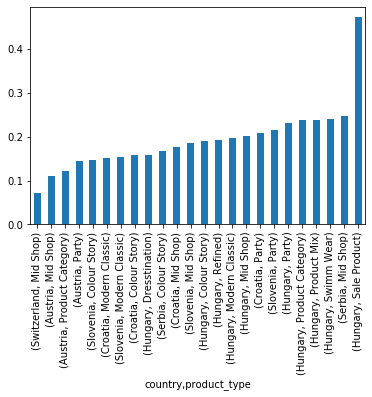

In [9]:
high_open = df_merged.loc[df_merged['rate_opening'] > 0.7]
(high_open
.groupby(['country', 'product_type'])['rate_click-throughs']
.mean()
.sort_values()
.plot(kind='bar') 
)



In [9]:
df_clean.sample(10
               )

,job_id,country_code,country,club_since,calendar_week,campaign,day_of_week_sent,month_sent,year,timestamp_start_send,timestamp_finish_send,delta_sending,delta_sending_norm,abs_sent,abs_received,abs_opening,rate_opening,abs_undelivered,rate_bounced,abs_deregistration,rate_churning,abs_click-throughs,rate_click-throughs,abs_spamed,object,name,mail_id,rate_spamed,season
771,377380,AT,Austria,2007,42,Generic,Saturday,October,2019,2019-10-19 06:01:38,2019-10-19 06:17:41,16.0,0.0,130360,130097,37399,0.287470,263,0.002017,145,0.001115,7296,0.056081,2,dein dress code,NL KW42 Dresses AT C 4101194260,4101194260,0.000015,Fall
1108,364499,PL,Poland,2007,39,Generic,Tuesday,September,2019,2019-09-24 06:01:05,2019-09-24 06:04:16,3.0,0.0,155618,155582,57997,0.372774,36,0.000231,107,0.000688,13062,0.083956,29,nowości tygodnia,NL KW39 Neuheiten PL C 4101193910,4101193910,0.000186,Fall
11412,64692,AT,Austria,2007,42,Generic,Monday,October,2017,2017-10-16 14:27:42,2017-10-16 18:09:47,222.0,0.0,5383,1891,7,0.003702,3492,0.648709,0,0.000000,1,0.000529,0,warm einpacken: neue jacken & mäntel,NL KW42 Jackets AT CS 44417421A,44417421,0.000000,Fall
5456,272598,SK,Slovakia,2017,10,Generic,Saturday,March,2019,2019-03-09 06:02:04,2019-03-09 06:05:28,3.0,0.0,127072,126794,32452,0.255943,278,0.002188,46,0.000363,8484,0.066912,1,jarné nákupné dni: -20% na váš nákup!,NL KW10 Shop Event SK AC 4105191071,4105191071,0.000008,Spring
3711,308799,CZ,Czech,2009,19,Generic,Sunday,May,2019,2019-05-12 06:01:48,2019-05-12 06:11:17,9.0,0.0,81026,80976,766,0.009460,50,0.000617,29,0.000358,138,0.001704,17,pouze dnes: -20% na všechno,NL KW19 Flower Print CZ AC Regain 4101191960,4101191960,0.000210,Spring
10556,101839,RO,Romania,2017,7,Generic,Tuesday,February,2018,2018-02-13 10:31:02,2018-02-13 10:31:50,0.0,0.0,85531,85507,18877,0.220766,24,0.000281,44,0.000515,7972,0.093232,0,-40 ron la blugi & descoperiți modelele de blu...,NL KW07 LP Denim RO AC 44418071A,44418071,0.000000,Winter
10596,98983,RO,Romania,2017,6,Generic,Tuesday,February,2018,2018-02-06 07:10:01,2018-02-06 07:10:25,0.0,0.0,85754,85742,17641,0.205745,12,0.000140,57,0.000665,7379,0.086061,0,vine primăvara! 🌷,NL KW06 Jackets RO C 44418061A,44418061,0.000000,Winter
4661,296502,SK,Slovakia,2017,15,Generic,Sunday,April,2019,2019-04-14 06:01:37,2019-04-14 06:08:37,7.0,0.0,50181,50138,9092,0.181340,43,0.000857,36,0.000718,1312,0.026168,0,jarné novinky & doručenie zadarmo,NL KW15 Spring Shirts SK AC 4101191550,4101191550,0.000000,Spring
1756,349740,SI,Slovenia,2017,34,Generic,Tuesday,August,2019,2019-08-20 06:01:55,2019-08-20 06:12:01,10.0,0.0,66964,66874,16942,0.253342,90,0.001344,38,0.000568,3541,0.052950,0,pozor: divje živali & vroče ponudbe 🐾,NL KW34 Animal Print SI AC 4101193410,4101193410,0.000000,Summer
3667,310326,CZ,Czech,2009,20,Generic,Thursday,May,2019,2019-05-16 06:01:50,2019-05-16 06:07:52,6.0,0.0,51140,51122,10384,0.203122,18,0.000352,35,0.000685,1766,0.034545,12,jedeme na festival! 💃🎶,NL KW20 Refined CZ 4101192030,4101192030,0.000235,Spring


Text(0, 0.5, 'rate_click-throughs')

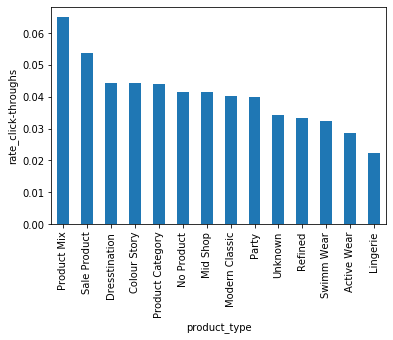

In [298]:
y_data = 'rate_click-throughs'
(df_merged
 .groupby(['product_type'])[[y_data]]
 .median()
 .sort_values(by=['rate_click-throughs'], ascending=False)[y_data]
 .plot(kind='bar')
)
plt.ylabel(y_data)

Text(0, 0.5, 'abs_sent')

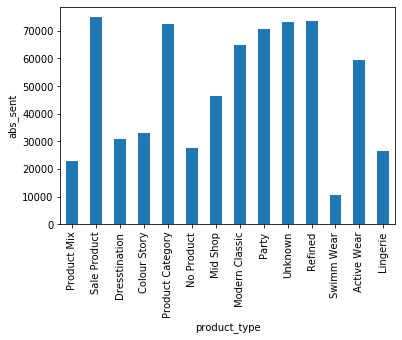

In [297]:
y_data = 'abs_sent'
(df_merged
 .groupby(['product_type'])[[y_data,'rate_click-throughs']]
 .median()
 .sort_values(by=['rate_click-throughs'], ascending=False)[y_data]
 .plot(kind='bar')
)
plt.ylabel(y_data)

In [20]:
df_merged

,job_id,country_code,country,club_since,calendar_week,campaign,day_of_week_sent,month_sent,year,timestamp_start_send,timestamp_finish_send,delta_sending,delta_sending_norm,abs_sent,abs_received,abs_opening,rate_opening,abs_undelivered,rate_bounced,abs_deregistration,rate_churning,abs_click-throughs,rate_click-throughs,abs_spamed,object,name,mail_id,rate_spamed,season,action_type,product_code,customer_type,testtype,tracker,product_type,regain_flag
0,408049,RS,Serbia,2017,49,Generic,Sunday,December,2019,2019-12-08 06:01:27,2019-12-08 06:11:51,10.0,0.0,68137,68084,19475,0.286044,53,0.000778,61,0.000896,4740,0.069620,4,topli džemperi za zimu,NL KW49 Knitwear RS C 4101194960,4101194960,0.000059,Winter,99,MS,CN,9,4101194960,Mid Shop,False
1,408047,SI,Slovenia,2017,49,Generic,Sunday,December,2019,2019-12-08 06:01:27,2019-12-08 06:11:46,10.0,0.0,64606,64549,18377,0.284698,57,0.000882,54,0.000837,3969,0.061488,3,topli puloverji za zimo,NL KW49 Knitwear SI C 4101194960,4101194960,0.000046,Winter,99,MS,CN,9,4101194960,Mid Shop,False
2,408043,HR,Croatia,2017,49,Generic,Sunday,December,2019,2019-12-08 06:01:33,2019-12-08 06:11:47,10.0,0.0,71361,71296,20758,0.291152,65,0.000911,41,0.000575,4330,0.060733,0,topli puloveri za zimu,NL KW49 Knitwear HR C 4101194960,4101194960,0.000000,Winter,99,MS,CN,9,4101194960,Mid Shop,False
3,408042,RO,Romania,2017,49,Generic,Sunday,December,2019,2019-12-08 06:01:43,2019-12-08 06:12:37,10.0,0.0,176883,176783,30676,0.173523,100,0.000565,99,0.000560,8799,0.049773,19,pulovere călduroase pentru iarnă,NL KW49 Knitwear RO C 4101194960,4101194960,0.000107,Winter,99,MS,CN,9,4101194960,Mid Shop,False
4,408041,HU,Hungary,2015,49,Generic,Sunday,December,2019,2019-12-08 06:01:28,2019-12-08 06:12:58,11.0,0.0,193941,193781,56946,0.293868,160,0.000825,103,0.000532,12235,0.063138,1,puha pulóverek télre,NL KW49 Knitwear HU C 4101194960,4101194960,0.000005,Winter,99,MS,CN,9,4101194960,Mid Shop,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7060,56582,AT,Austria,2007,38,Generic,Monday,September,2017,2017-09-18 15:02:23,2017-09-18 15:10:13,7.0,0.0,1508,1498,568,0.379172,10,0.006631,1,0.000668,261,0.174232,0,das perfekte kleid für den herbst: neue saison...,NL KW37 Herbstfarben AT C 4441738W1,4441738,0.000000,Fall,99,CS/MS,CN,SFMC,4441738W1,Colour Story,False
7061,56579,CZ,Czech,2009,38,Generic,Monday,September,2017,2017-09-18 14:55:28,2017-09-18 15:18:41,23.0,0.0,8708,8706,3838,0.440845,2,0.000230,2,0.000230,1586,0.182173,0,vaše ideální podzimní šaty: nové barvy na novo...,NL KW37 Herbstfarben CZ C 4441738W1,4441738,0.000000,Fall,99,CS/MS,CN,SFMC,4441738W1,Colour Story,False
7062,56577,HU,Hungary,2015,38,Generic,Monday,September,2017,2017-09-18 14:52:18,2017-09-18 15:11:37,19.0,0.0,7404,6255,3828,0.611990,1149,0.155186,2,0.000320,1479,0.236451,0,a tökéletes őszi egyberuha: új színek az új sz...,NL KW37 Herbstfarben HU C 4441738W1,4441738,0.000000,Fall,99,CS/MS,CN,SFMC,4441738W1,Colour Story,False
7063,56574,DE,Germany,2004,38,Generic,Monday,September,2017,2017-09-18 14:44:04,2017-09-18 15:09:29,25.0,0.0,18984,18867,5510,0.292044,117,0.006163,18,0.000954,2201,0.116659,0,das perfekte kleid für den herbst: neue saison...,NL KW37 Herbstfarben DE C 4441738W1,4441738,0.000000,Fall,99,CS/MS,CN,SFMC,4441738W1,Colour Story,False


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


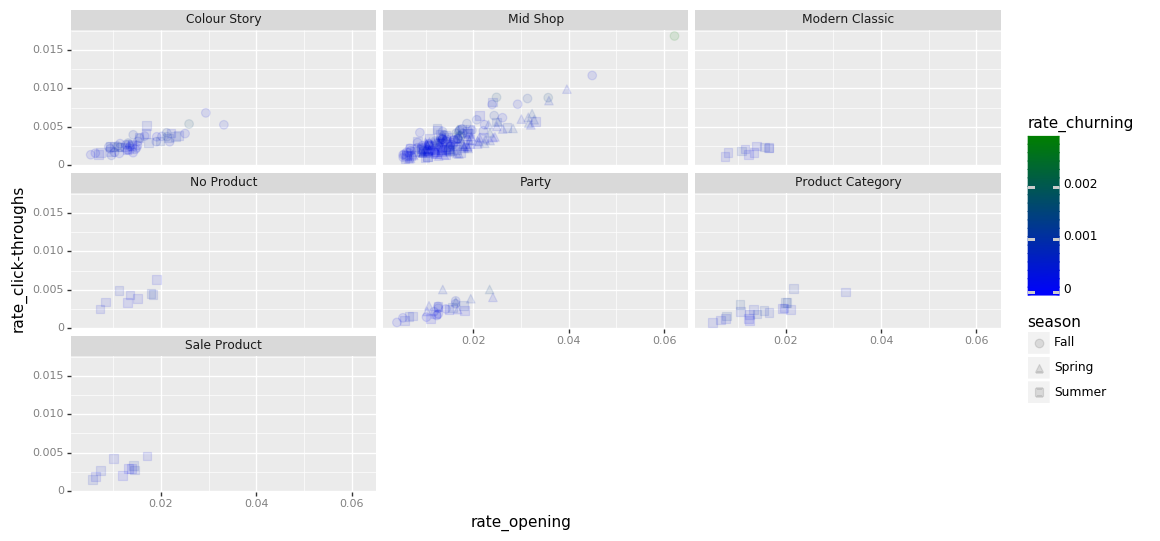

<ggplot: (-9223371916406469836)>

In [28]:
colors = {"Colour Story": "red", "Modern Classic": "blue", "Product Category": "green",
          "Party": "slateblue",  "No Product": "black",     "Product Mix": "mocassin",
          "Mid Shop": "yellow",  "DS": "cyan",              "Refined": "white",
          "Active Wear": "blue", "Swimm Wear": "red",       "Sale Product": "blue",
          "Lingerie": "pink", 
          "PY": "black", "SE": "black"}

# Get data to plot
dat_to_plot = df_merged[(df_merged["regain_flag"] == True)]
#                      & ((df_clean["country_code"] == "DE") | (df_clean["country_code"] == "PL"))]
                        #& (df_clean["country_code"] == "CZ")]
                       

# Order data to plot in consecutive weekday
months = ['January','February','March','April','May','June',
          'July', 'August', 'September', 'October', 'November', 'December']
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
#year = ['2017', '2018', '2019']
dat_to_plot['month_sent'] = pd.Categorical(dat_to_plot['month_sent'], months)
dat_to_plot['day_of_week_sent'] = pd.Categorical(dat_to_plot['day_of_week_sent'], days)
#dat_to_plot['year'] = pd.Categorical(dat_to_plot['month_sent'], year)
dat_to_plot.sort_values(['month_sent', 'year'])

my_custom_theme = p9.theme(axis_text_x = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=.5),
                           axis_text_y = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=1.0),
                           figure_size=(12, 6))
x_data = "rate_opening"
y_data = "rate_click-throughs"
(p9.ggplot() 
+ p9.geom_point(data    = dat_to_plot, alpha=0.1, size = 3,
                mapping = p9.aes(x_data, 
                                 y_data, 
                                 #fill='month_sent', 
                                 shape = 'season',
                                 color = 'rate_churning'))
+ p9.facet_wrap(["product_type"])
+ p9.scale_color_gradient(low = 'blue', high='green')
+ my_custom_theme
+ p9.labs(x=x_data, y=y_data))
#+ p9.ggtitle("Rates per Country"))

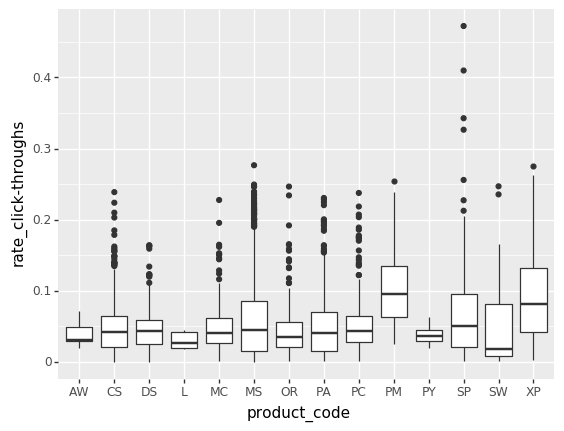

<ggplot: (-9223371888469678652)>

In [325]:
(p9.ggplot(data=dat_to_plot,
           mapping=p9.aes(x='product_code',
                          y='rate_click-throughs'))
    + p9.geom_boxplot()
)


# Data Expl

In [24]:
# Dropping object column for visualization cause increases row width :D
df_clean.sample(10)

,job_id,country_code,country,club_since,calendar_week,mail_id,campaign,day_of_week_sent,month_sent,year,timestamp_start_send,timestamp_finish_send,delta_sending,delta_sending_norm,abs_sent,abs_received,abs_opening,rate_opening,abs_undelivered,rate_bounced,abs_deregistration,rate_churning,abs_click-throughs,rate_click-throughs,abs_spamed,object,name,rate_spamed
3962,306371,CH,Switzerland,2012,18,4101191850,Generic,Sunday,May,2019,2019-05-05 08:03:40,2019-05-05 08:04:23,0.0,0.0,8395,8390,5824,0.694160,5,0.000596,12,0.001430,635,0.075685,0,dein kleid für den besonderen anlass!,NL KW18 Occasion Dresses CHD 4101191850,0.000000
5989,255192,NaN,NaN,NaN,6,444190503,Generic,Monday,February,2019,2019-02-04 10:10:39,2019-02-28 15:55:40,34905.0,28.0,1236,1180,855,0.724576,56,0.045307,1,0.000847,724,0.613559,0,dein 25% gutschein wartet auf dich - es fehlt ...,DE DOI Confirmation Request 444190503,0.000000
2916,321920,CH,Switzerland,2012,24,4101192460,Generic,Sunday,June,2019,2019-06-16 06:01:12,2019-06-16 06:06:51,5.0,0.0,27618,27600,7725,0.279891,18,0.000652,26,0.000942,486,0.017609,1,urlaubsfeeling garantiert! 🌊,NL KW24 Beach Looks CHD AC 4101192460,0.000036
10976,84370,AT,Austria,2007,52,52,Club,Wednesday,December,2017,2017-12-27 09:01:05,2017-12-27 09:01:33,0.0,0.0,9338,9319,1384,0.148514,19,0.002035,9,0.000966,232,0.024895,1,"%%firstname%%, ihre punkte sind nur noch bis 3...",CLUB KW52 Punkteverfall AT,0.000107
9140,168754,SK,Slovakia,2017,28,44418286,Generic,Sunday,July,2018,2018-07-15 06:17:43,2018-07-15 06:19:52,2.0,0.0,91894,91701,11209,0.122234,193,0.002100,40,0.000436,1658,0.018081,0,posledná šanca: -20% na váš nákup v aplikácii!,NL NF KW28 ShopEvent SK A 44418286A,0.000000
5157,282864,AT,Austria,2007,14,4101191420,Generic,Tuesday,April,2019,2019-04-02 06:01:35,2019-04-02 06:09:07,7.0,0.0,41435,41263,2571,0.062308,172,0.004151,54,0.001309,294,0.007125,5,blau machen im büro - so geht's!,NL KW14 Business AT C 4101191420,0.000121
4939,292762,AT,Austria,2007,14,4101191450,Generic,Sunday,April,2019,2019-04-07 06:02:07,2019-04-07 06:11:46,9.0,0.0,41076,40863,2318,0.056726,213,0.005186,44,0.001077,264,0.006461,7,dein outfit für den besonderen anlass & keine ...,NL KW14 Party AT AC 4101191450,0.000171
5920,255666,CZ,Czech,2009,6,4101190613,Generic,Tuesday,February,2019,2019-02-05 10:03:51,2019-02-05 10:04:55,1.0,0.0,23994,23986,6087,0.253773,8,0.000333,19,0.000792,1645,0.068582,5,tyto šaty přehlédnout nemůžete!,NL KW06 Dresstination CZ C 4101190613,0.000208
928,372801,NaN,NaN,NaN,41,444190504,Generic,Friday,December,2019,2019-10-11 09:49:37,2019-12-11 06:16:34,87626.0,6.0,14408,14209,7327,0.515659,199,0.013812,6,0.000422,4803,0.338025,6,letzte erinnerung: bitte bestätige deine anmel...,DE DOI Confirmation Request Reminder 444190504,0.000422
1860,348005,HU,Hungary,2015,33,4101193330,Generic,Thursday,August,2019,2019-08-15 06:03:23,2019-08-15 06:19:47,16.0,0.0,56818,56163,33893,0.603476,655,0.011528,50,0.000890,7822,0.139273,1,új outfit ötletek ☀️🍂,NL KW33 Allure Chic HU CS 4101193330,0.000018


NameError: name 'df1' is not defined

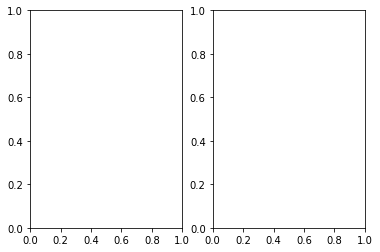

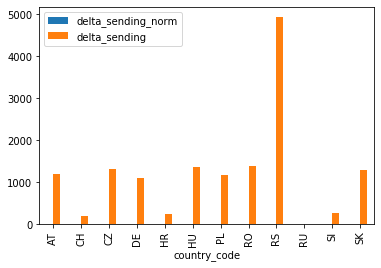

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2)
(df_clean
 .groupby(by='country_code')[['delta_sending_norm','delta_sending']]
 .mean()
 #.sort_values()
 .plot(kind='bar'))




df1.plot(ax=axes[0,0])
df2.plot(ax=axes[0,1])

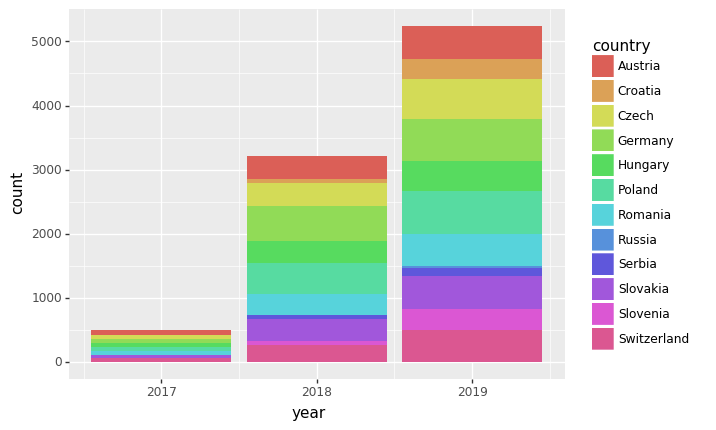

<ggplot: (-9223371866647261360)>

In [41]:
(p9.ggplot(df_clean.dropna())
+ p9.geom_bar(p9.aes(x= "year", fill="country"))
)

In [42]:
# Compute some descriptives
(df_clean
 .groupby(['country', 'campaign'])
 .apply(lambda d: pd.Series({
     "median_opening":  d['rate_opening'].median()*100,
     "median_click":    d['rate_click-throughs'].median()*100,
     "mean_opening":    d['rate_opening'].mean()*100,
     "mean_click":      d['rate_click-throughs'].mean()*100,     
     "std_click":       d['rate_click-throughs'].std(),
    # "median_churning": d['rate_churning'].median()*100,
    # "median_spamed":   d['rate_spamed'].median()*100
    # "club_since":      d['club_since'].median().round(decimals=0)
 }))
 .sort_values(by=['country'], ascending=True)
)

median_opening  median_click  mean_opening  mean_click  \
country     campaign                                                           
Austria     Club           21.984428      3.156188     22.828121    3.206596   
            Generic        23.709928      3.665988     24.622261    4.199130   
            Others         15.934996      2.956777     15.934996    2.956777   
Croatia     Club           26.115770      4.277542     24.782448    4.420363   
            Generic        30.921451      5.231547     33.335920    6.450129   
Czech       Club           16.589720      3.504566     17.696007    3.882831   
            Generic        19.627696      4.334184     23.139132    5.569508   
            Others         17.583347      6.712924     17.583347    6.712924   
Germany     Club           19.088040      2.957093     20.665861    3.121829   
            Generic        20.714199      3.163110     24.222224    4.012756   
            NonClub        20.789180      2.129990     20.789180    2.129990   
            Others         25.457283      3.486615     27.803942    3.472981   
Hungary     Club           26.067336      5.627414     25.339431    5.487973   
            Generic        28.712968      6.289979     29.174387    7.250841   
            Others         25.826870      6.178122     25.826870    6.178122   
Poland      Others         17.397759      7.746468     17.397759    7.746468   
            Club           13.442502      2.587948     14.507384    2.840874   
            Generic        15.012262      2.930722     17.744790    3.683450   
Romania     Club           17.223876      4.576827     18.273307    4.812647   
            Generic        17.177305      5.231266     18.140196    5.875068   
Russia      Generic        30.046948      8.215962     29.422577    8.877639   
Serbia      Club           25.619835      3.668257     24.895905    3.810088   
            Generic        31.342658      5.015409     31.671062    5.682758   
            Others         40.083496     14.100053     40.083496   14.100053   
Slovakia    Club           21.236160      4.336952     23.542828    4.671357   
            Generic        25.008288      5.864587     25.548305    6.657004   
Slovenia    Club           24.206350      4.341840     23.415155    4.220003   
            Generic        29.365964      5.295597     31.475004    6.518294   
Switzerland Generic        29.395516      2.700548     29.757114    3.196064   
            Club           28.135301      2.146926     28.833781    2.870153   
            Others         30.155568      4.272584     30.155568    4.272584   

                      std_click  
country     campaign             
Austria     Club       0.011282  
            Generic    0.033510  
            Others          NaN  
Croatia     Club       0.018071  
            Generic    0.054856  
Czech       Club       0.014793  
            Generic    0.046228  
            Others          NaN  
Germany     Club       0.011624  
            Generic    0.032783  
            NonClub    0.012208  
            Others     0.021790  
Hungary     Club       0.020311  
            Generic    0.054993  
            Others          NaN  
Poland      Others     0.056826  
            Club       0.013046  
            Generic    0.031119  
Romania     Club       0.031847  
            Generic    0.042431  
Russia      Generic    0.023905  
Serbia      Club       0.019806  
            Generic    0.042075  
            Others     0.063895  
Slovakia    Club       0.030452  
            Generic    0.049368  
Slovenia    Club       0.017131  
            Generic    0.055155  
Switzerland Generic    0.028390  
            Club       0.031341  
            Others     0.001785

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
Note that median and mean opening are quite different: <br>
Median opening is comparable between campaigns.<br>
Mean opening is higher for Generic campaigns. <br> 
</div>

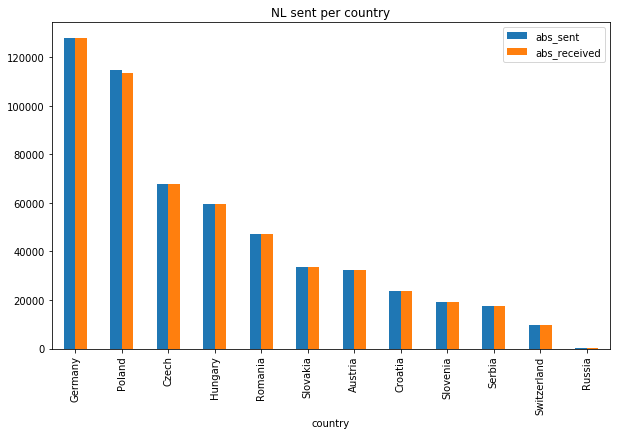

In [43]:
# Visualize mail traffic per country
(df_clean
 .groupby(['country'])
 .median()[['abs_sent','abs_received']]
 .sort_values(by='abs_sent',ascending=False)
 .plot(kind='bar',title='NL sent per country',figsize=(10,6)));

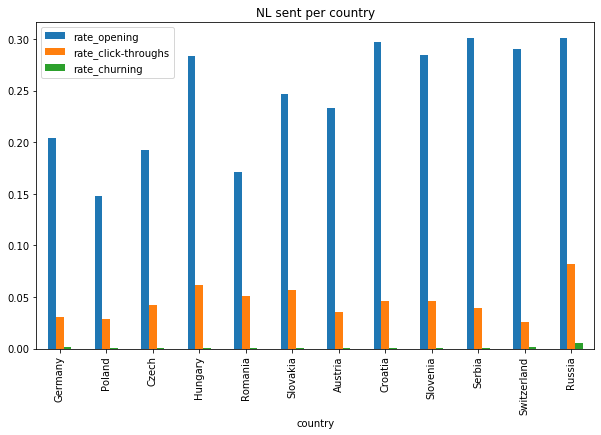

In [44]:
# Now let's look at rates rated by country of importance
(df_clean
 .groupby('country')
 .median() 
 .sort_values(by='abs_sent',ascending=False)[['rate_opening','rate_click-throughs','rate_churning']]
 .plot(kind='bar',title='NL sent per country',figsize=(10,6)));

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
I guess for now I'll focus on DE & PL, maybe CZ. <br>
</div>

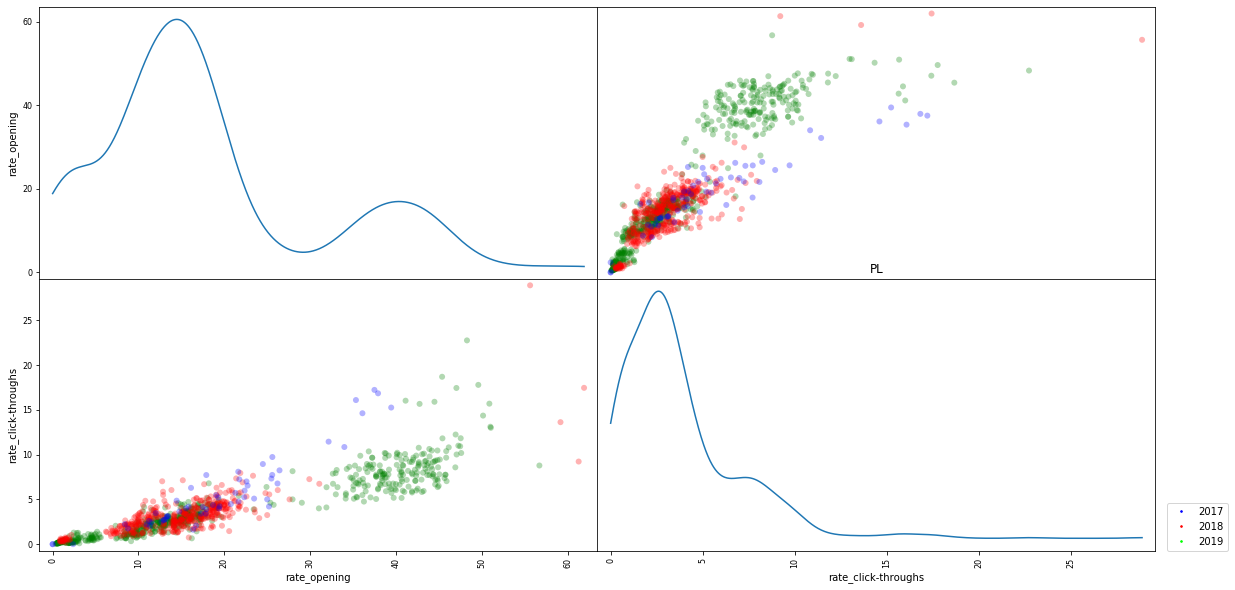

In [29]:
# Explore specific countries
selected_country = 'PL'
country_mask = df_clean['country_code'] == selected_country

color_function = {2017: "blue", 2018: "red", 2019: "green"}
colors = df_clean['country'].map(lambda x: color_function.get(x))

pltr = df_clean[country_mask]
colors = pltr['year'].map(lambda x: color_function.get(x))

pltr = pltr[['rate_opening', 'rate_click-throughs']]*100
pd.plotting.scatter_matrix(pltr, color = colors, 
                           alpha = 0.3,
                           figsize = (5, 5), 
                           diagonal='kde',
                           marker='o')
handles = [plt.plot([],[],color=plt.cm.brg(i/2.), ls="", marker=".", \
                    markersize=np.sqrt(10))[0] for i in range(3)]
labels=["2017", "2018", "2019"]

plt.legend(handles, labels, loc=(1.02,0))
plt.title(selected_country)
plt.gcf().set_size_inches(20, 10)

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
Does not seem to play a big role.... <br>
Seems that True object are less opened, but thats just about density, levels are comparable <br>
If you look at free shipping (keyword="versand"), same picture... <br>
</div>

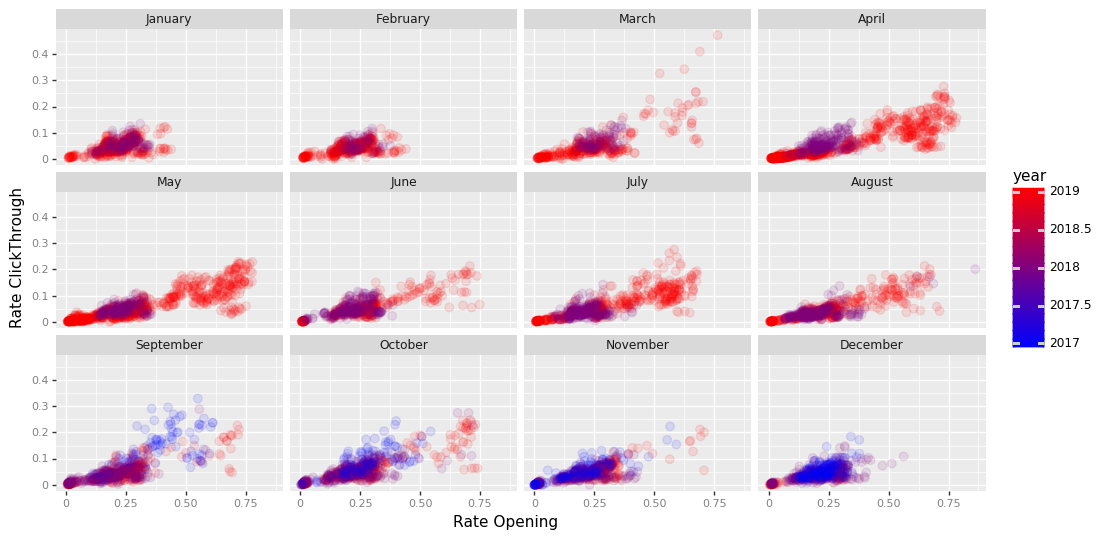

<ggplot: (-9223371882532917956)>

In [9]:
# Get data to plot
dat_to_plot = df_clean#[((df_clean["campaign"] == "External") | (df_clean["campaign"] == "Generic"))
#                      & ((df_clean["country_code"] == "DE") | (df_clean["country_code"] == "PL"))]
                        #& (df_clean["country_code"] == "CZ")]
                       

# Order data to plot in consecutive weekday
months = ['January','February','March','April','May','June',
          'July', 'August', 'September', 'October', 'November', 'December']
#year = ['2017', '2018', '2019']
dat_to_plot['month_sent'] = pd.Categorical(dat_to_plot['month_sent'], months)
#dat_to_plot['year'] = pd.Categorical(dat_to_plot['month_sent'], year)
dat_to_plot.sort_values(['month_sent', 'year'])

my_custom_theme = p9.theme(axis_text_x = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=.5),
                           axis_text_y = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=1.0),
                           figure_size=(12, 6))

(p9.ggplot() 
+ p9.geom_point(data    = dat_to_plot, alpha=0.1, size = 3,
                mapping = p9.aes("rate_opening", "rate_click-throughs", color='year'))
+ p9.facet_wrap(["month_sent"])
+ p9.scale_color_gradient(low = 'blue', high='red')
+ my_custom_theme
+ p9.labs(x="Rate Opening", y="Rate ClickThrough"))
#+ p9.ggtitle("Rates per Country"))

C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


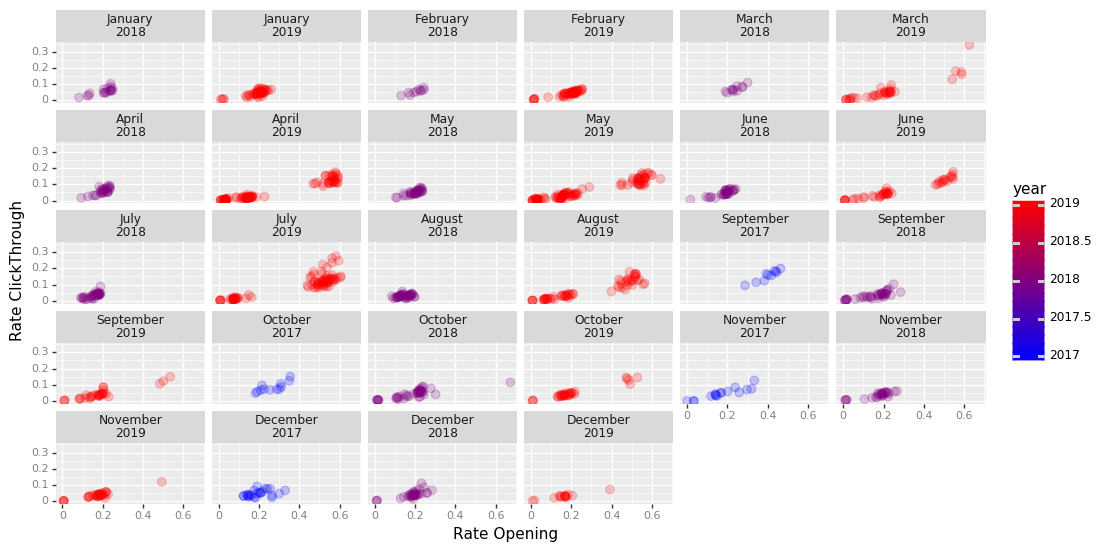

<ggplot: (-9223371845629822600)>

In [31]:
# Get data to plot
dat_to_plot = df_clean[((df_clean["country_code"] == "CZ"))]
                      #  & (df_clean["country_code"] == "DE")]
                       

# Order data to plot in consecutive weekday
months = ['January','February','March','April','May','June',
          'July', 'August', 'September', 'October', 'November', 'December']
#year = ['2017', '2018', '2019']
dat_to_plot['month_sent'] = pd.Categorical(dat_to_plot['month_sent'], months)
#dat_to_plot['year'] = pd.Categorical(dat_to_plot['month_sent'], year)
dat_to_plot.sort_values(['month_sent', 'year'])

my_custom_theme = p9.theme(axis_text_x = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=.5),
                           axis_text_y = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=1.0),
                           figure_size=(12, 6))

(p9.ggplot() 
+ p9.geom_point(data    = dat_to_plot, alpha=0.2, size = 3,
                mapping = p9.aes("rate_opening", "rate_click-throughs", color='year'))
+ p9.facet_wrap(["month_sent", "year"])
+ p9.scale_color_gradient(low = 'blue', high='red')
+ my_custom_theme
+ p9.labs(x="Rate Opening", y="Rate ClickThrough"))
#+ p9.ggtitle("Rates per Country"))

In [26]:
df_clean.columns

Index(['job_id', 'country_code', 'country', 'club_since', 'cal_week',
       'mail_id', 'campaign', 'day_of_week_sent', 'month_sent', 'year',
       'timestamp_start_send', 'timestamp_finish_send', 'delta_sending',
       'abs_sent', 'abs_received', 'abs_opening', 'rate_opening',
       'abs_undelivered', 'rate_bounced', 'abs_deregistration',
       'rate_churning', 'abs_click-throughs', 'rate_click-throughs',
       'abs_spamed', 'object', 'rate_spamed'],
      dtype='object')

In [41]:
(df_clean[df_clean['rate_opening'] > 0.4]
.groupby('country')
.count())

,job_id,country_code,club_since,cal_week,mail_id,campaign,day_of_week_sent,month_sent,year,timestamp_start_send,timestamp_finish_send,delta_sending,abs_sent,abs_received,abs_opening,rate_opening,abs_undelivered,rate_bounced,abs_deregistration,rate_churning,abs_click-throughs,rate_click-throughs,abs_spamed,object,rate_spamed
country,,,,,,,,,,,,,,,,,,,,,,,,,
Austria,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88,88
Croatia,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72
Czech,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195,195
Germany,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202
Hungary,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94
Poland,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113
Romania,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77
Serbia,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
Slovakia,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92


In [32]:
(dat_to_plot
 .loc[lambda d: d['year'] == 2019]
 .groupby(by='calendar_week')
 .mean()['rate_opening'])
 #.loc[lambda d: d['timestamp'] < pd.to_datetime(before_period[1])])

calendar_week
1     0.126552
2     0.202456
3     0.168707
4     0.200553
5     0.190922
6     0.218156
7     0.137552
8     0.195252
9     0.184447
10    0.165784
11    0.224640
12    0.179550
13    0.238305
14    0.240288
15    0.243265
16    0.226227
17    0.212452
18    0.246350
19    0.266481
20    0.273812
21    0.266145
22    0.315361
23    0.287446
24    0.340238
25    0.329532
26    0.162384
27    0.396294
28    0.424152
29    0.402606
30    0.337739
31    0.336755
32    0.385935
33    0.207869
34    0.157224
35    0.192382
36    0.179388
37    0.198826
38    0.241416
39    0.174850
40    0.211781
41    0.193218
42    0.233736
43    0.232301
44    0.130776
45    0.146256
46    0.205655
47    0.206825
48    0.172258
49    0.154336
50    0.107657
51    0.023119
Name: rate_opening, dtype: float64

In [48]:
(df_clean
 .loc[lambda d: d['year'] == 2019]
 .groupby(by='month_sent')
 .mean()['rate_opening'])
 #.loc[lambda d: d['timestamp'] < pd.to_datetime(before_period[1])])

month_sent
April        0.279425
August       0.280663
December     0.283514
February     0.240486
January      0.216898
July         0.320300
June         0.260509
March        0.260948
May          0.284067
November     0.240848
October      0.306417
September    0.286650
Name: rate_opening, dtype: float64

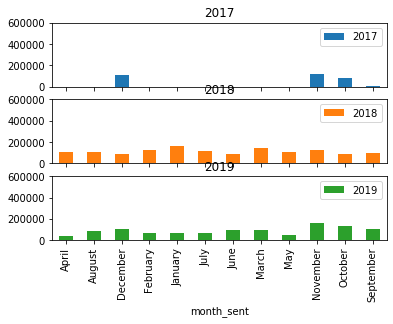

In [47]:
pd.DataFrame(df_clean
 .groupby(by=["year", "month_sent"])        
 #mean()['abs_sent']
# .sort_values() 
 .agg('mean')
 .unstack(1)['abs_sent'].T
 .plot(kind='bar', subplots=True,ylim=[0,600000])
);

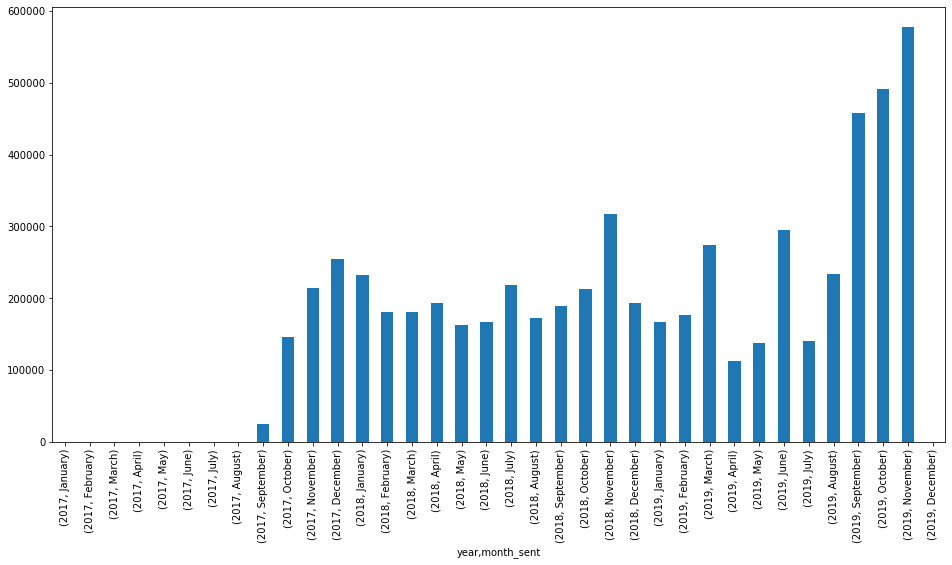

In [17]:
(dat_to_plot
 .groupby(by=["year", "month_sent"])        
 .mean()['abs_sent']
 #.sort_values() 
 .plot(kind='bar')
);

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
Two observations to validate with team: <br>
1) External campaigns <b>decreased</b> strongly from 2017 to 2018, <b>AND NO CAMPAIGN IN 2019??<b> <br>
2) Generic campaigns <b>increased</b> strongly from 2018 to 2019 <br>

Also, 3) Club only started in 2019??

Given the small number of other and club actions, Ill look ony into Generic & External
</div>

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
Given the weigh of each campaign, Ill look at Generic & External only. <br>
Id like to look at other parameters, such as week & month 
</div>

C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\envs\emailing\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\envs\emailing\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 10 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\envs\emailing\lib\site-packages\plotnine\guides\guides.py:261: PlotnineWarning: geom_point legend : Removed 1 rows containing missing values.
  gdef = gdef.create_geoms(plot)


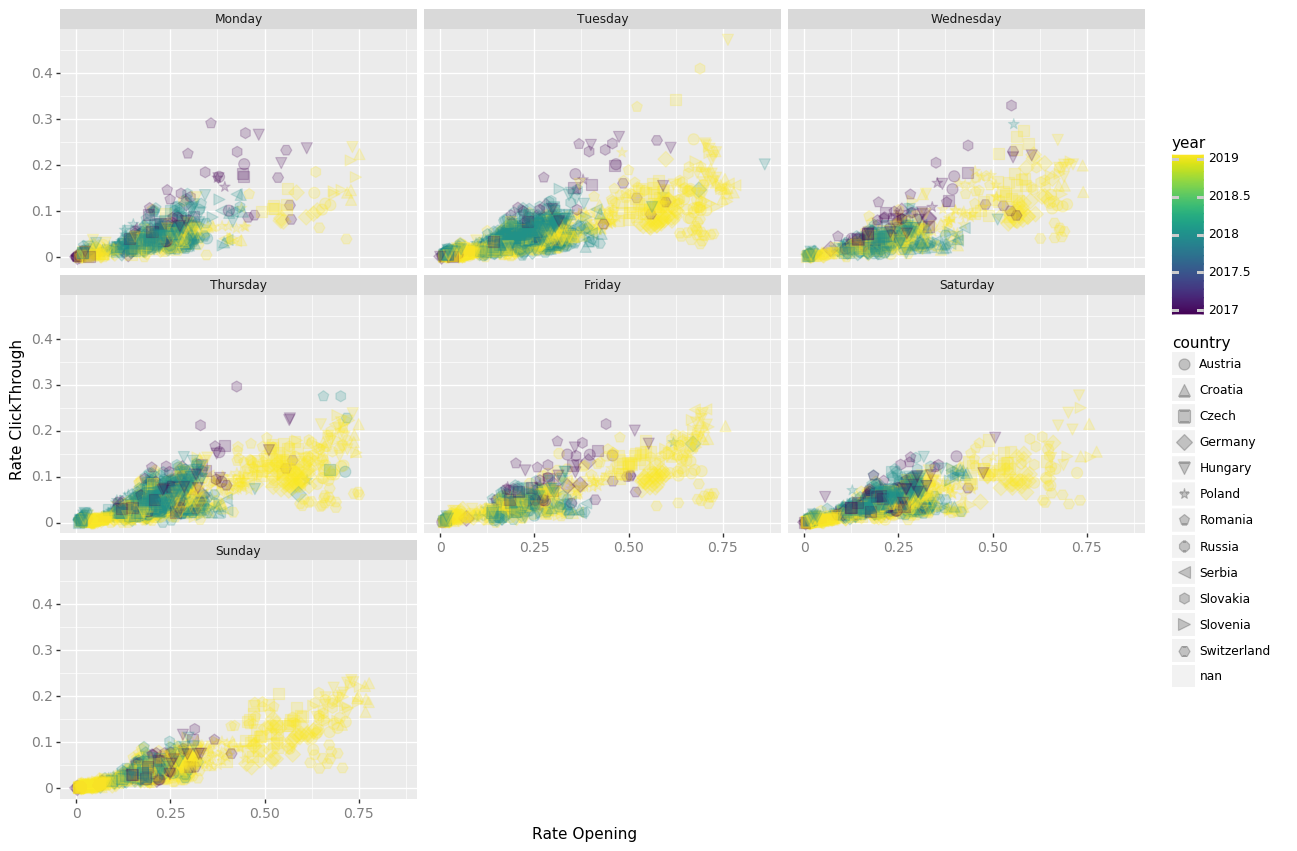

<ggplot: (-9223371864305876668)>

In [14]:
# Get data to plot
dat_to_plot = df_clean[((df_clean["campaign"] == "External") | (df_clean["campaign"] == "Generic"))]
#                      & ((df_clean["country_code"] == "DE") | (df_clean["country_code"] == "PL"))]

# Order data to plot in consecutive weekday

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
dat_to_plot.loc[:, 'day_of_week_sent'] = pd.Categorical(dat_to_plot.loc[:,'day_of_week_sent'], days)
dat_to_plot.sort_values('day_of_week_sent')

# Define theme
my_custom_theme = p9.theme(axis_text_x = p9.element_text(color="grey", size=10,
                                                         angle=0, hjust=.5),
                           axis_text_y = p9.element_text(color="grey", size=10,
                                                         angle=0, hjust=1.0),
                           figure_size=(14, 10))
# Plot
(p9.ggplot() 
+ p9.geom_point(data = dat_to_plot,
                alpha=0.2, 
                size =4,
                mapping = p9.aes("rate_opening", "rate_click-throughs",  color="year", shape ="country"))
+ p9.facet_wrap(["day_of_week_sent"])
+ my_custom_theme
+ p9.labs(x="Rate Opening", y="Rate ClickThrough"))
#+ p9.ggtitle("Rates per Country"))

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
Some days have less openings, in particular monday. <br>
Lets look whether maybe less mails are sent these days, altough that would not affect opening rates. <br>
Im pooling across countries cause data doesnt suggest split is relevant. <br>
</div>

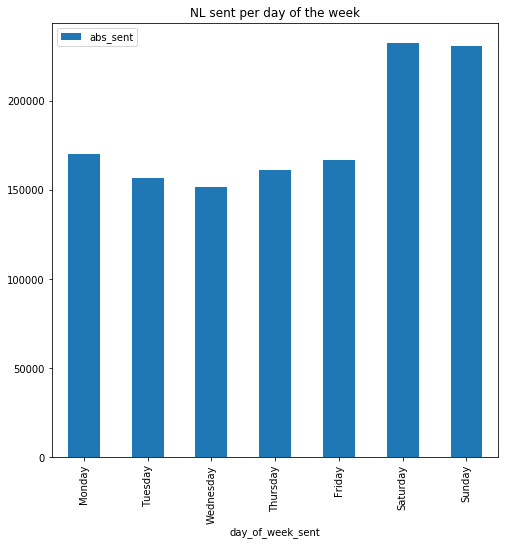

In [15]:
# Since PL and DE seem the larger markets, lets focus on them
# dat_to_plot = df_clean[((df_clean["country_code"] == 'DE') 
#                      | (df_clean["country_code"] == 'PL'))]
dat_sent_per_day = df_clean.loc[(df_clean["country_code"] == 'DE')| (df_clean["country_code"] == 'PL'), 
                                   ["abs_sent", "day_of_week_sent","country_code"]]

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
dat_sent_per_day['day_of_week_sent'] = pd.Categorical(dat_sent_per_day['day_of_week_sent'], days)

(dat_sent_per_day
 .groupby(by=["day_of_week_sent"])
 .mean() 
 .sort_values('day_of_week_sent')
 .plot(kind='bar',title='NL sent per day of the week',figsize=(8,8))
);

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
Consider adapting the number of NL sent to the opening rate on given days?. <br>
</div>

In [16]:
# Lets see whether we can explain these clusters
# Probably some objects are more attractive than others
pd.DataFrame(dat_to_plot['object']).sample(5)

,object
4933,-20% la rochii & livrare gratuită 💃
2883,nadčasový trend: čipka
7885,orsay goes whatsapp! neugierig?
301,tjedne novosti
5694,neue trends für büro 💼


<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
Looks like generic mailing is quite loved <br>
Ill look a bit deeper into word classification to see whether I can find clues about why... <br>
</div>

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
There are some clear clusters happening in both DE & PL countries. <br>
I guess we want to identify what's in the high clusters that makes them more openable. <br>
</div>

In [17]:
(df_clean['object'].str.find("sale") > 1).sum()

475

In [18]:
(df_clean['object'].str.find("SALE") > 1).sum()

0

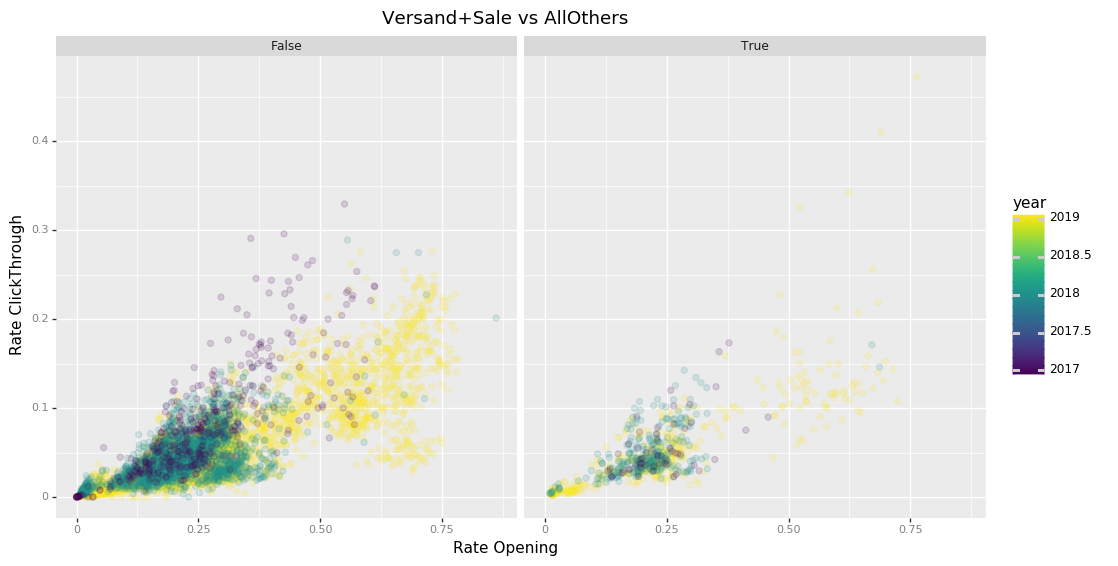

<ggplot: (-9223371864304389176)>

In [19]:
# Maybe mails with objects that propose some keywords?
keyword = "versand"
dat_to_plot = df_clean.assign(idx_reduction = df_clean['object'].str.find(keyword) > 1)
# Try two obvious keywords at once
idx_keyword = ((dat_to_plot['object'].str.find("versand") > 1) | (dat_to_plot['object'].str.find("sale") > 1))
dat_to_plot = dat_to_plot.assign(idx_reduction = idx_keyword)

my_custom_theme = p9.theme(axis_text_x = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=.5),
                           axis_text_y = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=1.0),
                           figure_size=(12, 6))

(p9.ggplot() 
+ p9.geom_point(data    = dat_to_plot, alpha=0.15, size = 2,
                mapping = p9.aes("rate_opening", "rate_click-throughs", color='year'))
+ p9.facet_wrap(["idx_reduction"])
+ my_custom_theme
+ p9.labs(x="Rate Opening", y="Rate ClickThrough")
+ p9.ggtitle("Versand+Sale vs AllOthers"))

# (p9.ggplot() 
# + p9.geom_histogram(data    = dat_to_plot, size = 2,
#                 mapping = p9.aes("rate_opening"))
# + p9.facet_wrap(["idx_reduction"])
# + my_custom_theme
# + p9.labs(x="Rate Opening", y="Count"))
# #+ p9.ggtitle("Rates per Country"))

### Word classification

In [20]:
# Im gonna focus on one language at once since language plays a role here
# Im also selecting only the two main campaigns,
DOI = df_clean[((df_clean['country_code'] == 'DE')  | (df_clean['country_code'] == 'AT'))]
             #& ((df_clean['campaign'] == 'Generic') | (df_clean['campaign'] == 'External')
             #| (df_clean['campaign'] == 'Club'))
             #& (df_clean['abs_sent'] > 100)]

In [21]:
(df_clean['object'].str.find("sale") > 1).sum()

475

<div class="alert alert-block alert-success">
<b>Intermediate commentary:</b> <br> 
I am using the frequency–inverse document frequency measure. <br>
tf-idf vectorization of a corpus of text documents assigns each word in a document a number that is <br> 
1) proportional to its frequency in the document and <br>
2) inversely proportional to the number of documents in which it occurs. <br>

Very common words, such as “a” or “the”, thereby receive heavily discounted tf-idf scores, in contrast to words that are very specific to the document in question. The result is a matrix of tf-idf scores with one row per document and as many columns as there are different words in the dataset.  <br>
</div>

In [22]:
# Convert the NL objects into a document-term matrix:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2,lowercase=True)
spars_mat = vect.fit_transform(DOI.object)

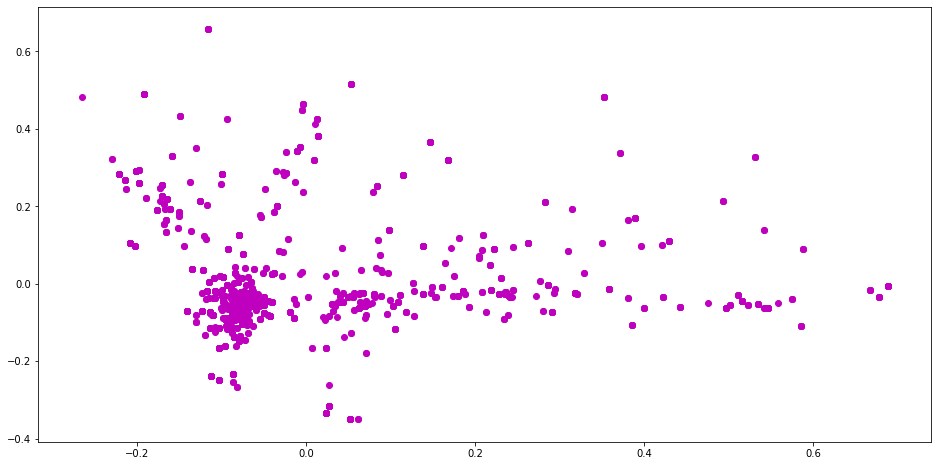

In [23]:
# I perform a dimensionality reduction to visualize the distribution
from sklearn.decomposition import PCA
spars_mat_dense = spars_mat.todense()
coords = PCA(n_components=2).fit_transform(spars_mat_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m');

In [24]:
# Function takes a single row of the tf-idf matrix and return the top_n highest scoring words
def top_tfidf_feats(row, features, top_n=20):
    # Use argsort to produce the indices that would order the row by tf-idf value 
    # reverse them (into descending order) 
    # select the first top_n.
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['feature', 'score'])
    return df

# Convert single row into dense format
def top_feats_in_doc(spars_mat, features, row_id, top_n=25):
    row = np.squeeze(spars_mat[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [25]:
# features is a variable that holds a list of all the words in the tf-idf’s vocabulary
features = vect.get_feature_names()
# Print example 
top_feats = top_feats_in_doc(spars_mat, features, 1,top_n=25)
print(top_feats_in_doc(spars_mat, features, 1, 10))

             feature     score
0            special  0.567640
1                ein  0.504163
2               dich  0.397362
3  salutationsubject  0.365743
4                für  0.363235
5    frühlingsjacken  0.000000
6             gehört  0.000000
7               geht  0.000000
8           gefeiert  0.000000
9         geburtstag  0.000000


In [26]:
# This function will compute the mean score for each features previously identified
# Important is to filter out the words with relatively low scores.
# This is because common words, such as ‘a’ or ‘the’, while having low tf-idf scores within each document, 
# are so frequent that when averaged over all documents they would otherwise easily dominate all other terms.

# Calling this function with grp_ids=None, gives us the most important words across the whole corpus.
def top_mean_feats(spars_mat, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = spars_mat[grp_ids].toarray()
    else:
        D = spars_mat.toarray()
        D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [27]:
# Print top_n words across the whole corpus:
print(top_mean_feats(spars_mat, features, top_n=10))

             feature     score
0                auf  0.051985
1                 20  0.050678
2               sale  0.034958
3      versandkosten  0.034657
4              keine  0.028878
5                für  0.027545
6  salutationsubject  0.023723
7            kleider  0.023141
8               neue  0.021997
9            einkauf  0.021661


<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
There is some clear pattern here: <br>
Reduction offers of 20% seems very common, <br>
as well as free shipping. <br>    
</div>

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
One way would be to let the machine cluster the data <br>
Another way would be to give meaningful clusters (eg, campaigns) <br>    
    
For machine clustering, Im gonna use the KMeans approach. n_clusters is based on the trends I saw in the data <br>
I played with the random state go get clustering that made sense, but I need to learn further about this. <br>    
</div>

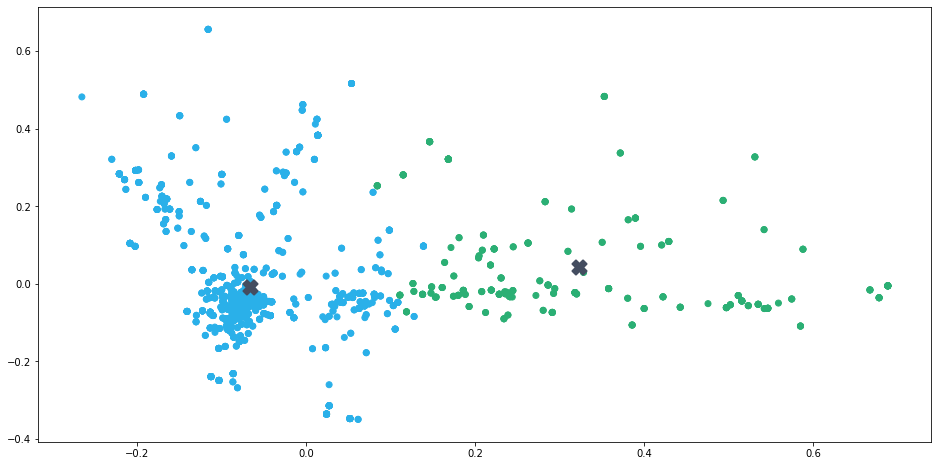

In [28]:
from sklearn.cluster import KMeans
n_clusters = 2
clf = KMeans(n_clusters=n_clusters, 
             max_iter=100, 
             init='k-means++', 
             n_init=10,
             verbose=0, 
             # Where does the algorithm start. I defined this after looking at different results
             random_state=8)
labels = clf.fit_predict(spars_mat)

# As done before, use PCA to reduce dimensions
spars_mat_dense = spars_mat.todense()
pca = PCA(n_components=2).fit(spars_mat_dense)
coords = pca.transform(spars_mat_dense)

# Lets plot it again, but this time we colour-code the outputed clusters
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E"]
colors = [label_colors[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c=colors);

# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], 
            centroid_coords[:, 1], 
            marker='X', 
            s=200, 
            linewidths=2, 
            c='#444d60');

<div class="alert alert-block alert-warning">
<b>Intermediate commentary:</b> <br> 
Clustering is done above <br>
What I don't like is that the clusters dont make much sense depending on which data is used <br>
But I keep it there for possible use. <br>    
</div>

In [29]:
# Calculate the mean tf-idf scores per category (cluster or predetermined categories)
def top_feats_per_cluster(spars_mat, y, features, min_tfidf=0.1, top_n=25):
    dfs = []    
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(spars_mat, features, ids,  min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [30]:
# Plotting function from https://buhrmann.github.io/tfidf-analysis.html
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    #plt.show()

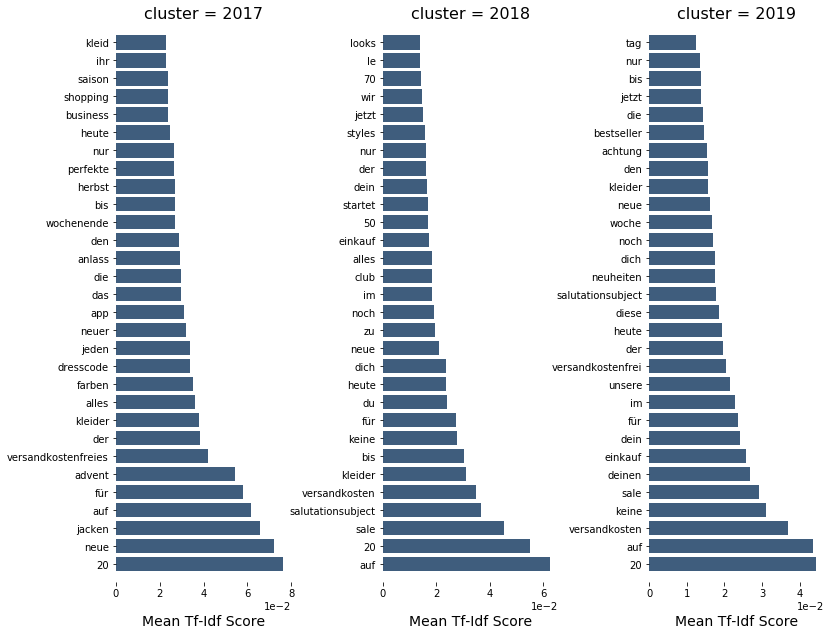

In [31]:
plot_tfidf_classfeats_h(top_feats_per_cluster(spars_mat, DOI['year'], features, 0.1, 30))

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
The picture is not very clean... <br>
Seems like wording has not  changed much in the last two years <br>    
</div>

<div class="alert alert-block alert-info">
<b>Intermediate commentary:</b> <br> 
Im gonna explore another path now <br>
Simply looking whether some words categories are correlated with opening rate <br>   
</div>

In [81]:
# Storing the scores in test
score_list = top_feats_per_cluster(spars_mat, DOI['year'], features, 0.1, 30)
# Just gonna look at the firt cluster for now
score_list[1].sort_values('score', ascending=False).head(2)

,feature,score
0,auf,0.061837
1,20,0.053171


In [71]:
DOI_copy = DOI.copy()

In [72]:
# Erase non alphanumeric entries
DOI_copy.loc[:,'object'] = DOI.loc[:, 'object'].replace('[^a-zA-Z0-9 ]', '', regex=True)
# Lower case all characters
DOI_copy.loc[:,'object'] = DOI.loc[:, 'object'].apply(lambda x: x.lower())

In [85]:
object_list = DOI_copy['object'].str.split(expand=True)

# Get max  score in object
DOI_copy['mean_score'] = np.nan
DOI_copy['max_score']  = np.nan
DOI_copy['median_score']  = np.nan
DOI_copy['min_score']  = np.nan
for i in range(len(DOI_copy)):
    DOI_copy['mean_score'].iloc[i] = np.mean(score_list[1]['score'][score_list[1]['feature']
                                                                   .isin(object_list.iloc[i])])
    DOI_copy['max_score'].iloc[i]  = np.max(score_list[1]['score'][score_list[1]['feature']
                                                                    .isin(object_list.iloc[i])])
    DOI_copy['median_score'].iloc[i]  = np.median(score_list[1]['score'][score_list[1]['feature']
                                                                .isin(object_list.iloc[i])])
    DOI_copy['min_score'].iloc[i]  = np.max(score_list[1]['score'][score_list[1]['feature']
                                                                .isin(object_list.iloc[i])])

# AAAAAHHHHH I CANNOT MANAGE TO ADD THE SCORES WITHOUT A FOR LOOP !!!!    
# def apply_score(dataf):
#      return(dataf
#      .assign(max_score = lambda d: [test_list[1]['feature'].isin(d['object'].str.split(expand=True))]))    

C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [90]:
DOI_copy.dropna().drop(columns={'object'})

,job_id,country_code,country,club_since,cal_week,mail_id,campaign,day_of_week_sent,month_sent,year,timestamp_start_send,timestamp_finish_send,delta_sending,abs_sent,abs_received,abs_opening,rate_opening,abs_undelivered,rate_bounced,abs_deregistration,rate_churning,abs_click-throughs,rate_click-throughs,abs_spamed,rate_spamed,mean_score,max_score,median_score,min_score
10,389867,DE,Germany,2004,46,4101194630,Generic,Friday,November,2019,2019-11-15 06:03:00,2019-11-15 06:16:54,13.0,703797,702951,6807,0.009683,846,0.001202,31,0.000044,1226,0.001744,3,0.000004,0.017780,0.017780,0.017780,0.017780
23,387893,DE,Germany,2004,46,4101194610,Generic,Monday,November,2019,2019-11-11 06:01:40,2019-11-11 06:23:38,21.0,188767,188563,2277,0.012076,204,0.001081,116,0.000615,631,0.003346,4,0.000021,0.035289,0.061837,0.031990,0.061837
34,387016,DE,Germany,2004,46,4101194610,Generic,Monday,November,2019,2019-11-11 06:07:43,2019-11-11 06:28:27,20.0,703155,702182,145963,0.207871,973,0.001384,697,0.000993,26799,0.038165,15,0.000021,0.038588,0.061837,0.038588,0.061837
55,386922,DE,Germany,2004,45,4101194570,Generic,Sunday,November,2019,2019-11-10 06:02:49,2019-11-10 06:30:44,27.0,887935,886735,141905,0.160031,1200,0.001351,981,0.001106,21946,0.024749,35,0.000039,0.016180,0.016180,0.016180,0.016180
77,386427,DE,Germany,2004,45,4101194560,Generic,Saturday,November,2019,2019-11-09 06:12:43,2019-11-09 06:37:17,24.0,887198,885989,152751,0.172407,1209,0.001363,910,0.001027,25604,0.028899,36,0.000041,0.017955,0.020287,0.017955,0.020287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8659,58135,DE,Germany,2004,37,4441738,Generic,Friday,September,2017,2017-09-22 14:37:43,2017-09-22 15:15:28,37.0,23925,21410,8421,0.393321,2515,0.105120,20,0.000934,2842,0.132742,0,0.000000,0.023734,0.027180,0.023734,0.027180
8667,57814,DE,Germany,2004,37,4441738,Generic,Thursday,September,2017,2017-09-21 15:57:22,2017-09-21 16:28:26,31.0,13953,11552,3258,0.282029,2401,0.172078,7,0.000606,1363,0.117988,0,0.000000,0.023734,0.027180,0.023734,0.027180
8682,57380,DE,Germany,2004,37,4441738,Generic,Wednesday,September,2017,2017-09-20 14:26:00,2017-09-20 15:04:39,38.0,18964,16413,4254,0.259185,2551,0.134518,17,0.001036,1646,0.100286,0,0.000000,0.023734,0.027180,0.023734,0.027180
8688,56972,DE,Germany,2004,37,4441738,Generic,Tuesday,September,2017,2017-09-19 14:46:15,2017-09-19 15:18:54,32.0,18954,16446,4625,0.281223,2508,0.132320,11,0.000669,1814,0.110300,0,0.000000,0.023734,0.027180,0.023734,0.027180


In [92]:
DOI_copy.columns

Index(['job_id', 'country_code', 'country', 'club_since', 'cal_week',
       'mail_id', 'campaign', 'day_of_week_sent', 'month_sent', 'year',
       'timestamp_start_send', 'timestamp_finish_send', 'delta_sending',
       'abs_sent', 'abs_received', 'abs_opening', 'rate_opening',
       'abs_undelivered', 'rate_bounced', 'abs_deregistration',
       'rate_churning', 'abs_click-throughs', 'rate_click-throughs',
       'abs_spamed', 'object', 'rate_spamed', 'mean_score', 'max_score',
       'median_score', 'min_score'],
      dtype='object')

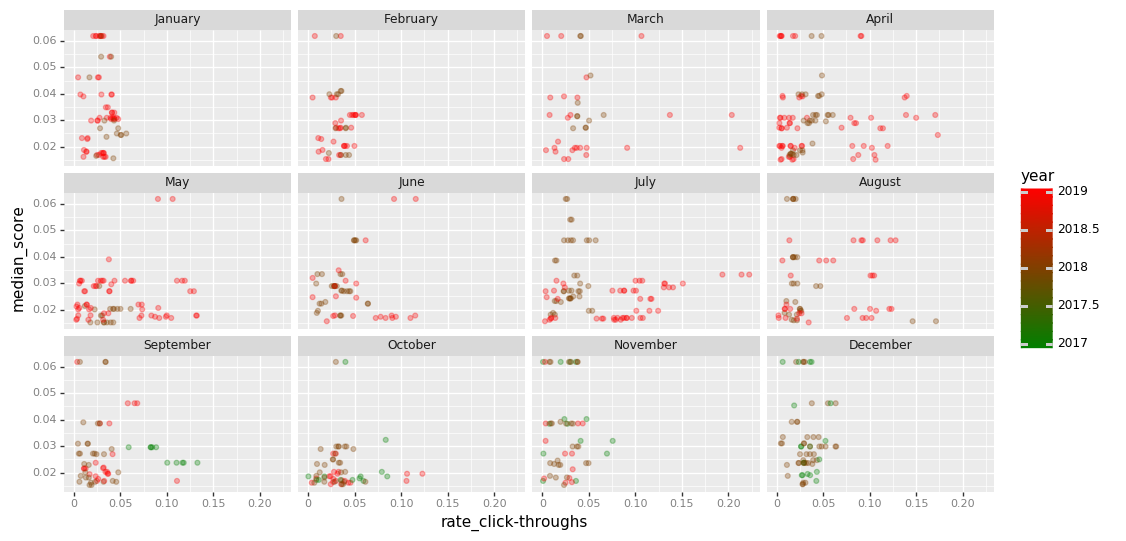

<ggplot: (-9223371903406324444)>

In [93]:
DOI_copy['month_sent'] = pd.Categorical(DOI_copy['month_sent'], months)
dat_to_plot = DOI_copy.sort_values('month_sent').dropna().drop(columns={'object'})

my_custom_theme = p9.theme(axis_text_x = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=.5),
                           axis_text_y = p9.element_text(color="grey", size=8,
                                                         angle=0, hjust=1.0),
                           figure_size=(12, 6))

(p9.ggplot() + 
p9.geom_point(data = dat_to_plot, alpha = 0.3, 
              mapping = p9.aes("rate_click-throughs", "median_score", color ='year'))
+ p9.scale_color_gradient(low='green', high='red')
+ p9.facet_wrap(["month_sent"])
+ my_custom_theme)